# HGT + Temporal Transformer Encoder Training on Google Colab

This notebook trains the **HGT + Temporal Transformer Encoder** for Energy Balance Model (EBM) on an **A100 GPU**.

## Architecture Overview

1. **HGT (Heterogeneous Graph Transformer)**: Spatial encoding across heterogeneous nodes
2. **Temporal Transformer**: Self-attention across time dimension
3. **Encoder-only**: Outputs embeddings for EBM training (no decoder)

## Setup Requirements

- **GPU**: A100 (40GB or 80GB)
- **Runtime**: Python 3.10+
- **Google Drive**: Repository mounted at `/content/drive/MyDrive/benchmark`

## 1. Mount Google Drive

In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set up paths
REPO_PATH = '/content/drive/MyDrive/benchmark'
os.chdir(REPO_PATH)

print(f"Current directory: {os.getcwd()}")
print(f"Repository contents:")
!ls -la

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/benchmark
Repository contents:
total 258
drwx------ 2 root root   4096 Dec  1 08:19  code_writings
-rw------- 1 root root   3577 Nov 28 16:54  COLAB_QUICK_START.md
-rw------- 1 root root   8471 Nov 28 16:52  COLAB_TRAINING_GUIDE.md
drwx------ 2 root root   4096 Dec  1 08:19  config
-rw------- 1 root root 131628 Dec  1 14:29 'Copie de HGT_Transformer_Training_Colab.ipynb'
drwx------ 2 root root   4096 Dec  1 08:19  docs
drwx------ 2 root root   4096 Dec  1 08:19  experimental
drwx------ 2 root root   4096 Dec  1 08:19  extracted_pdfs
drwx------ 2 root root   4096 Dec  1 08:19  .git
-rw------- 1 root root     75 Sep 17 22:08  .gitignore
-rw------- 1 root root  28504 Nov 28 16:51  HGT_Transformer_Training_Colab.ipynb
drwx------ 2 root root   4096 Dec  1 08:19  hybrid
-rw------- 1 root root   1095 Sep 17 22:03  LICENSE
dr

## 2. Verify GPU (A100)

In [2]:
import torch

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ WARNING: No GPU detected! Please enable GPU in Runtime > Change runtime type")

PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB
Number of GPUs: 1


## 3. Install Dependencies

In [3]:
import torch

# Force install PyTorch 2.5.1 which has known compatible PyG wheels
# This prevents the long "Building wheels" process
print("🔄 Installing stable PyTorch 2.5.1 and compatible PyG wheels...")

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

# Install other dependencies
!pip install numpy scipy tqdm matplotlib seaborn pandas

print("\n✅ All dependencies installed! If you see version errors later, please restart the runtime (Runtime > Restart session). ")

🔄 Installing stable PyTorch 2.5.1 and compatible PyG wheels...
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 146.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s et

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 150.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 132.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00

✅ All dependencies installed! If you see version errors later, please restart the runtime (Runtime > Restart session). 


## 4. Verify Dataset

In [3]:
import json
from pathlib import Path
import numpy as np

# Base repository path
REPO_PATH = Path('/content/drive/MyDrive/benchmark')

# Check dataset
data_dir = REPO_PATH / 'outputs/graphs/hetero_temporal_v1'
index_path = data_dir / 'dataset_index.json'

if not index_path.exists():
    print(f"❌ ERROR: Dataset index not found at {index_path}")
    print("Please ensure your repository is correctly mounted from Google Drive.")
else:
    # Load index
    with open(index_path, 'r') as f:
        index_data = json.load(f)

    print(f"✅ Dataset found!")
    print(f"Total graphs: {len(index_data['entries'])}")

    # Check first graph
    # Handle Windows paths in JSON and join with REPO_PATH
    first_graph_rel = index_data['entries'][0]['graph_file'].replace('\\', '/')
    first_graph = REPO_PATH / first_graph_rel

    if first_graph.exists():
        sample = np.load(first_graph, allow_pickle=True)
        print(f"\nSample graph info:")
        print(f"  - Node features shape: {sample['node_features'].shape}")
        print(f"  - Edge index shape: {sample['edge_index'].shape}")
        print(f"  - Node types shape: {sample['node_types'].shape}")
        print(f"  - Metadata: {sample['meta'].item()}")

        node_feature_dim = sample['node_features'].shape[1]
        print(f"\n📊 Node feature dimension: {node_feature_dim}")
    else:
        print(f"❌ ERROR: First graph file not found at {first_graph}")
        print(f"Attempted path: {first_graph}")

✅ Dataset found!
Total graphs: 2000

Sample graph info:
  - Node features shape: (57984, 14)
  - Edge index shape: (2, 63769)
  - Node types shape: (57984,)
  - Metadata: {'N_base': 604, 'T': 96, 'temporal_edges': ['soc', 'ramp', 'dr'], 'time_encoding': 'sinusoidal', 'target_horizon': 0, 'schema_version': '2.0-temporal'}

📊 Node feature dimension: 14


## 5. Configuration

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    # Data
    repo_path: str = '/content/drive/MyDrive/benchmark'
    data_dir: str = '/content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v1'
    train_split: float = 0.8

    # Model - AUGMENTÉ grâce à économie mémoire
    hidden_dim: int = 64          # ✅ 4x plus que 32
    num_spatial_layers: int = 1    # ✅ Hiérarchie correcte
    num_temporal_layers: int = 1   # ✅ Capture temporalité
    num_heads: int = 4             # ✅ Attention riche
    dropout: float = 0.15

    # Training
    loss_type: str = 'contrastive'
    epochs: int = 150
    batch_size: int = 1            # ✅ Peut monter à 3-4
    lr: float = 3e-4
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    warmup_epochs: int = 10

    # Loss hyperparams
    max_nodes: int = 256           # Subsample nodes
    neg_sample_ratio: float = 0.1  # 20% de N*T comme négatifs
    temperature: float = 0.07

    # Output
    save_dir: str = '/content/drive/MyDrive/benchmark/outputs/encoders/hgt_transformer_optimized'
    save_embeddings: bool = True
    save_freq: int = 10

    # Device
    device: str = 'cuda'
    num_workers: int = 0

config = TrainingConfig()

print("📋 Training Configuration:")
print(f"  Model: HGT + Temporal Transformer")
print(f"  Batch size: {config.batch_size}")
print(f"  Attention heads: {config.num_heads}")
print(f"  Hidden dim: {config.hidden_dim}")
print(f"  Device: {config.device}")

📋 Training Configuration:
  Model: HGT + Temporal Transformer
  Batch size: 1
  Attention heads: 4
  Hidden dim: 64
  Device: cuda


## 6. Setup Training Components

In [5]:
import sys
from pathlib import Path
import json
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

# Add repo path to sys.path
REPO_ROOT = Path('/content/drive/MyDrive/benchmark')
sys.path.insert(0, str(REPO_ROOT))

from src.gnn.models.temporal_hetero_gnn import HGTTemporalTransformer, TemporalGraphDataset

# Load dataset
print("Loading dataset...")
# Use config.data_dir if available, else hardcode
data_dir = Path(config.data_dir)
index_path = data_dir / "dataset_index.json"

with open(index_path, 'r') as f:
    index_data = json.load(f)

# Fix path construction
# Use REPO_ROOT defined above instead of config.repo_path to avoid AttributeError
graph_files = []
for e in index_data["entries"]:
    # Normalize path (replace backslash with forward slash) and join with repo_path
    rel_path = e["graph_file"].replace('\\', '/')
    graph_files.append(REPO_ROOT / rel_path)

print(f"Found {len(graph_files)} graphs")

# Get node feature dim from first graph
if not graph_files[0].exists():
    raise FileNotFoundError(f"Graph file not found: {graph_files[0]}")

sample_data = np.load(graph_files[0], allow_pickle=True)
node_feature_dim = sample_data["node_features"].shape[1]
print(f"Node feature dim: {node_feature_dim}")

# Create dataset (no target selection for encoder training)
dataset = TemporalGraphDataset(graph_files, target_indices=None)

# Split dataset
train_size = int(config.train_split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Train: {train_size}, Val: {val_size}")

# Create loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Loading dataset...
Found 2000 graphs
Node feature dim: 14
Train: 1600, Val: 400
Train batches: 1600
Val batches: 400


## 7. Create Model

In [6]:
# Create model
import gc

# Delete old model if exists to free memory
if 'model' in globals():
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 Old model deleted and memory cleared.")

print("Creating HGT + Temporal Transformer model...")
model = HGTTemporalTransformer(
    node_feature_dim=node_feature_dim,
    hidden_dim=config.hidden_dim,
    num_spatial_layers=config.num_spatial_layers,
    num_temporal_layers=config.num_temporal_layers,
    num_heads=config.num_heads,
    dropout=config.dropout,
)
model = model.to(config.device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model created!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1e6:.2f} MB (fp32)")

# Optimizer with warmup
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay
)

# Cosine annealing scheduler with warmup
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=config.warmup_epochs
)
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config.epochs - config.warmup_epochs
)
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[config.warmup_epochs]
)

print(f"\n📚 Optimizer: AdamW (lr={config.lr}, wd={config.weight_decay})")
print(f"📚 Scheduler: Warmup ({config.warmup_epochs} epochs) + Cosine Annealing")

Creating HGT + Temporal Transformer model...

✅ Model created!
  Total parameters: 221,440
  Trainable parameters: 221,440
  Model size: ~0.89 MB (fp32)

📚 Optimizer: AdamW (lr=0.0003, wd=1e-05)
📚 Scheduler: Warmup (10 epochs) + Cosine Annealing


In [7]:
import re
import importlib
import torch
from src.gnn.models import temporal_hetero_gnn

# Path to the model file
file_path = '/content/drive/MyDrive/benchmark/src/gnn/models/temporal_hetero_gnn.py'

print(f"🔄 Patching {file_path} for Mixed Precision support (Round 2)...")

with open(file_path, 'r') as f:
    content = f.read()

# Target line: h_new.index_add_(0, dst_idx, attn_out)
# Fix: h_new.index_add_(0, dst_idx, attn_out.to(h_new.dtype))

pattern = r"(h_new\.index_add_\(0, dst_idx, attn_out\))"
replacement = r"h_new.index_add_(0, dst_idx, attn_out.to(h_new.dtype))"

new_content, count = re.subn(pattern, replacement, content)

if count > 0:
    # Backup
    with open(file_path + ".bak2", 'w') as f:
        f.write(content)

    # Write patched content
    with open(file_path, 'w') as f:
        f.write(new_content)

    print(f"✅ Applied fix to {count} location(s).")

    # Reload the module
    importlib.reload(temporal_hetero_gnn)
    from src.gnn.models.temporal_hetero_gnn import HGTTemporalTransformer
    print("✅ Module reloaded successfully.")
else:
    print("⚠️ Patch pattern not found. It might have been applied already.")
    # Debug context
    if "index_add_" in content:
        print("Found 'index_add_' usage:")
        for line in content.splitlines():
            if "index_add_" in line:
                print(line.strip())

🔄 Patching /content/drive/MyDrive/benchmark/src/gnn/models/temporal_hetero_gnn.py for Mixed Precision support (Round 2)...
⚠️ Patch pattern not found. It might have been applied already.
Found 'index_add_' usage:
h_new.index_add_(0, dst_idx, attn_out.to(h_new.dtype))
h_new.index_add_(0, dst_idx, attn_out.to(h_new.dtype))


In [8]:
# Re-create model again with the updated class
import gc

if 'model' in globals():
    del model
    gc.collect()
    torch.cuda.empty_cache()

print("Re-initializing model with Round 2 patches...")
model = HGTTemporalTransformer(
    node_feature_dim=node_feature_dim,
    hidden_dim=config.hidden_dim,
    num_spatial_layers=config.num_spatial_layers,
    num_temporal_layers=config.num_temporal_layers,
    num_heads=config.num_heads,
    dropout=config.dropout,
)
model = model.to(config.device)

# Re-initialize optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay
)

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=config.warmup_epochs
)
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config.epochs - config.warmup_epochs
)
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[config.warmup_epochs]
)

print("✅ Model re-initialized. Please run the training cell again.")

Re-initializing model with Round 2 patches...
✅ Model re-initialized. Please run the training cell again.


## 8. Loss Functions

In [9]:
import torch.nn.functional as F
import torch


def contrastive_loss_hybrid(embeddings, temperature=0.07, max_nodes=512, max_negatives=2048):
    """
    InfoNCE contrastive loss - HYBRIDE ULTRA-OPTIMISÉ

    Combine deux stratégies d'économie mémoire:
    1. Subsampling des nodes (comme votre version)
    2. Sampling des négatifs au lieu de matrice complète

    Mémoire: O(N*T*max_negatives) au lieu de O(N²*T²)

    Args:
        embeddings: [N, T, D] tensor
        temperature: Softmax temperature
        max_nodes: Maximum nodes pour subsample (si N > max_nodes)
        max_negatives: Nombre de négatifs à sampler par anchor
    """
    N, T, D = embeddings.shape
    device = embeddings.device

    # Étape 1: Subsample nodes si nécessaire
    node_indices_kept = None
    if N > max_nodes:
        perm = torch.randperm(N, device=device)
        node_indices_kept = perm[:max_nodes]
        embeddings = embeddings[node_indices_kept]  # [max_nodes, T, D]
        N = max_nodes

    # Flatten to [N*T, D]
    flat = embeddings.view(N * T, D)
    flat = F.normalize(flat, dim=1)

    # Étape 2: Pour chaque anchor, calculer seulement avec positifs + sample de négatifs
    total_loss = 0.0
    num_valid_pairs = 0

    # Créer les paires positives (timesteps adjacents)
    for i in range(N):
        for t in range(T - 1):
            anchor_idx = i * T + t
            positive_idx = i * T + t + 1

            # Similarité avec le positif
            pos_sim = torch.dot(flat[anchor_idx], flat[positive_idx]) / temperature

            # Sample des négatifs (exclure anchor et positive)
            all_indices = torch.arange(N * T, device=device)
            mask = (all_indices != anchor_idx) & (all_indices != positive_idx)
            neg_pool = all_indices[mask]

            # Limiter le nombre de négatifs
            if neg_pool.size(0) > max_negatives:
                neg_perm = torch.randperm(neg_pool.size(0), device=device)[:max_negatives]
                neg_indices = neg_pool[neg_perm]
            else:
                neg_indices = neg_pool

            # Similarités avec négatifs (batch matmul efficient)
            neg_sims = torch.matmul(flat[neg_indices], flat[anchor_idx]) / temperature

            # InfoNCE: log(exp(pos) / (exp(pos) + sum(exp(neg))))
            all_sims = torch.cat([pos_sim.unsqueeze(0), neg_sims])
            loss = -F.log_softmax(all_sims, dim=0)[0]

            total_loss += loss
            num_valid_pairs += 1

    if num_valid_pairs == 0:
        return torch.tensor(0.0, device=device, requires_grad=True)

    return total_loss / num_valid_pairs


def contrastive_loss_hybrid_vectorized(embeddings, temperature=0.07, max_nodes=512, max_negatives=2048):
    """
    VERSION VECTORISÉE (plus rapide) de la loss hybride

    Traite tous les anchors d'un coup au lieu d'une boucle
    """
    N, T, D = embeddings.shape
    device = embeddings.device

    # Subsample nodes si nécessaire
    if N > max_nodes:
        perm = torch.randperm(N, device=device)
        embeddings = embeddings[perm[:max_nodes]]
        N = max_nodes

    # Flatten et normaliser
    flat = embeddings.view(N * T, D)
    flat = F.normalize(flat, dim=1)

    # Créer les indices des paires positives
    node_ids = torch.arange(N, device=device).repeat_interleave(T - 1)
    time_ids = torch.arange(T - 1, device=device).repeat(N)

    anchor_indices = node_ids * T + time_ids           # [N*(T-1)]
    positive_indices = node_ids * T + (time_ids + 1)   # [N*(T-1)]

    num_pairs = anchor_indices.size(0)

    # Embeddings des anchors et positifs
    anchor_embs = flat[anchor_indices]      # [num_pairs, D]
    positive_embs = flat[positive_indices]  # [num_pairs, D]

    # Similarités positives
    pos_sims = (anchor_embs * positive_embs).sum(dim=1) / temperature  # [num_pairs]

    # Sample négatifs pour chaque anchor
    # Stratégie: pour chaque anchor, sample aléatoirement depuis tous les autres
    total_nodes = N * T

    # Créer masque d'exclusion (anchor et son positive)
    neg_sims_list = []

    for i in range(num_pairs):
        # Tous les indices sauf anchor et positive
        exclude_mask = torch.ones(total_nodes, dtype=torch.bool, device=device)
        exclude_mask[anchor_indices[i]] = False
        exclude_mask[positive_indices[i]] = False

        valid_negatives = torch.where(exclude_mask)[0]

        # Sample
        if valid_negatives.size(0) > max_negatives:
            sampled = valid_negatives[torch.randperm(valid_negatives.size(0), device=device)[:max_negatives]]
        else:
            sampled = valid_negatives

        # Similarités
        neg_sims = torch.matmul(flat[sampled], anchor_embs[i]) / temperature
        neg_sims_list.append(neg_sims)

    # Padding pour avoir même taille (pour vectorisation)
    max_len = max(ns.size(0) for ns in neg_sims_list)
    neg_sims_padded = torch.full((num_pairs, max_len), float('-inf'), device=device)

    for i, ns in enumerate(neg_sims_list):
        neg_sims_padded[i, :ns.size(0)] = ns

    # Combiner pos et neg
    all_sims = torch.cat([pos_sims.unsqueeze(1), neg_sims_padded], dim=1)  # [num_pairs, 1+max_negatives]

    # Log-softmax et prendre le premier (positif)
    loss = -F.log_softmax(all_sims, dim=1)[:, 0].mean()

    return loss


# VERSION RECOMMANDÉE: Compromis vitesse/mémoire
def contrastive_loss_optimized(embeddings, temperature=0.07, max_nodes=512, neg_sample_ratio=0.2):
    """
    VERSION OPTIMALE - Meilleur compromis vitesse/mémoire

    Au lieu de sampler max_negatives, sample un ratio de la population totale

    Args:
        embeddings: [N, T, D]
        temperature: Température softmax
        max_nodes: Subsample nodes (si N > max_nodes)
        neg_sample_ratio: Ratio de négatifs à sampler (0.2 = 20% de N*T)
    """
    N, T, D = embeddings.shape
    device = embeddings.device

    # Subsample nodes si nécessaire
    if N > max_nodes:
        perm = torch.randperm(N, device=device)
        embeddings = embeddings[perm[:max_nodes]]
        N = max_nodes

    # Flatten et normaliser
    flat = embeddings.view(N * T, D)
    flat = F.normalize(flat, dim=1)

    total_nodes = N * T
    max_negatives = max(100, int(total_nodes * neg_sample_ratio))  # Au moins 100 négatifs

    # Indices des paires positives
    node_ids = torch.arange(N, device=device).repeat_interleave(T - 1)
    time_ids = torch.arange(T - 1, device=device).repeat(N)
    anchor_indices = node_ids * T + time_ids
    positive_indices = node_ids * T + (time_ids + 1)

    # Batch processing: traiter par chunks pour économiser mémoire
    chunk_size = 256
    num_pairs = anchor_indices.size(0)
    total_loss = 0.0

    for chunk_start in range(0, num_pairs, chunk_size):
        chunk_end = min(chunk_start + chunk_size, num_pairs)
        chunk_anchors = anchor_indices[chunk_start:chunk_end]
        chunk_positives = positive_indices[chunk_start:chunk_end]

        # Embeddings du chunk
        anchor_embs = flat[chunk_anchors]
        positive_embs = flat[chunk_positives]

        # Similarités positives
        pos_sims = (anchor_embs * positive_embs).sum(dim=1, keepdim=True) / temperature

        # Sample négatifs communs pour tout le chunk (plus efficace)
        all_neg_indices = torch.randperm(total_nodes, device=device)[:max_negatives]
        neg_embs = flat[all_neg_indices]  # [max_negatives, D]

        # Similarités négatives (batch matmul)
        neg_sims = torch.matmul(anchor_embs, neg_embs.t()) / temperature  # [chunk_size, max_negatives]

        # Combiner
        all_sims = torch.cat([pos_sims, neg_sims], dim=1)  # [chunk_size, 1+max_negatives]

        # Loss
        chunk_loss = -F.log_softmax(all_sims, dim=1)[:, 0].mean()
        total_loss += chunk_loss * (chunk_end - chunk_start)

    return total_loss / num_pairs


print("✅ Loss functions defined (3 versions optimisées)")
print("   - contrastive_loss_hybrid: Maximum économie mémoire (loop-based)")
print("   - contrastive_loss_hybrid_vectorized: Version vectorisée (plus rapide)")
print("   - contrastive_loss_optimized: RECOMMANDÉE (meilleur compromis)")

✅ Loss functions defined (3 versions optimisées)
   - contrastive_loss_hybrid: Maximum économie mémoire (loop-based)
   - contrastive_loss_hybrid_vectorized: Version vectorisée (plus rapide)
   - contrastive_loss_optimized: RECOMMANDÉE (meilleur compromis)


## 9. Training Loop

In [10]:
from tqdm.notebook import tqdm
import time
import torch
from torch.utils.checkpoint import checkpoint


def train_epoch_ultra_optimized(model, loader, optimizer, device, loss_type):
    """Training ultra-optimisé avec subsampling des nodes."""
    model.train()
    total_loss = 0.0
    num_batches = 0

    accumulation_steps = 1  # ✅ Pas d'accumulation avec batch_size=1

    pbar = tqdm(loader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(pbar):
        batch = batch.to(device, non_blocking=True)

        # Get N_base and T
        if hasattr(batch, 'N_base'):
            N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        else:
            continue

        if hasattr(batch, 'T'):
            T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()
        else:
            continue

        # ✅ SUBSAMPLE NODES pour économiser mémoire dans le forward
        max_nodes_forward = 256  # Limiter à 256 base nodes
        if N_base > max_nodes_forward:
            # Subsample les nodes ET leurs edges
            node_indices = torch.randperm(N_base, device=device)[:max_nodes_forward]

            # Créer un mask pour les nodes à garder (répété pour chaque timestep)
            keep_mask = torch.zeros(N_base * T, dtype=torch.bool, device=device)
            for t in range(T):
                keep_mask[node_indices + t * N_base] = True

            # Filtrer nodes
            batch.x = batch.x[keep_mask]
            batch.node_type = batch.node_type[keep_mask]

            # Filtrer edges (garder seulement ceux qui connectent les nodes gardés)
            edge_mask = keep_mask[batch.edge_index[0]] & keep_mask[batch.edge_index[1]]
            batch.edge_index = batch.edge_index[:, edge_mask]
            batch.edge_type = batch.edge_type[edge_mask]

            # Remap edge indices
            old_to_new = torch.full((N_base * T,), -1, dtype=torch.long, device=device)
            old_to_new[keep_mask] = torch.arange(keep_mask.sum(), device=device)
            batch.edge_index = old_to_new[batch.edge_index]

            N_base = max_nodes_forward

        node_type = batch.node_type if hasattr(batch, 'node_type') else None

        # Wrapper pour checkpointing
        def model_forward(*inputs):
            x, edge_index, edge_type, nt = inputs
            return model(
                x, edge_index, edge_type, nt,
                N_base, T,
                batch=None,  # Single graph
                return_sequence=True,
            )

        # Forward avec autocast + checkpointing
        with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
            embeddings = checkpoint(
                model_forward,
                batch.x,
                batch.edge_index,
                batch.edge_type,
                node_type,
                use_reentrant=False
            )

        # Loss (float32 pour stabilité)
        embeddings = embeddings.float()

        loss = contrastive_loss_optimized(
            embeddings,
            temperature=0.07,
            max_nodes=256,
            neg_sample_ratio=0.1
        )

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.grad_clip)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Cleanup périodique
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / max(num_batches, 1)


print("✅ Training loop with node subsampling")

✅ Training loop with node subsampling


## 10. Train Model

In [11]:
import os

# Optimization for memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Create save directory
save_dir = Path(config.save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

import gc

# Clear GPU memory before starting
print("🧹 Clearing GPU cache...")
torch.cuda.empty_cache()
gc.collect()

# Training history
history = {
    'train_loss': [],
    'lr': [],
    'epoch_time': []
}

best_loss = float('inf')

print(f"\n🚀 Starting training for {config.epochs} epochs...\n")
print(f"Loss type: {config.loss_type}")
print(f"Device: {config.device}")
print(f"Batch size: {config.batch_size}")
print(f"Precision: bfloat16 (AMP)\n")

for epoch in range(1, config.epochs + 1):
    start_time = time.time()

    # Train
    train_loss = train_epoch_ultra_optimized(model, train_loader, optimizer, config.device, config.loss_type)

    # Update scheduler
    scheduler.step()

    # Record history
    epoch_time = time.time() - start_time
    history['train_loss'].append(train_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    history['epoch_time'].append(epoch_time)

    # Print progress
    print(f"Epoch {epoch:3d}/{config.epochs} | "
          f"Loss: {train_loss:.6f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Time: {epoch_time:.2f}s")

    # Save best model
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': train_loss,
            'config': config,
        }, save_dir / "best_encoder.pt")
        print(f"  💾 Saved best model (loss: {best_loss:.6f})")

    # Save checkpoint periodically
    if epoch % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': train_loss,
            'history': history,
            'config': config,
        }, save_dir / f"checkpoint_epoch_{epoch}.pt")
        print(f"  💾 Saved checkpoint at epoch {epoch}")

print(f"\n✅ Training complete!")
print(f"Best loss: {best_loss:.6f}")
print(f"Model saved to: {save_dir}")

🧹 Clearing GPU cache...

🚀 Starting training for 150 epochs...

Loss type: contrastive
Device: cuda
Batch size: 1
Precision: bfloat16 (AMP)



Training:   0%|          | 0/1600 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 11. Visualize Training

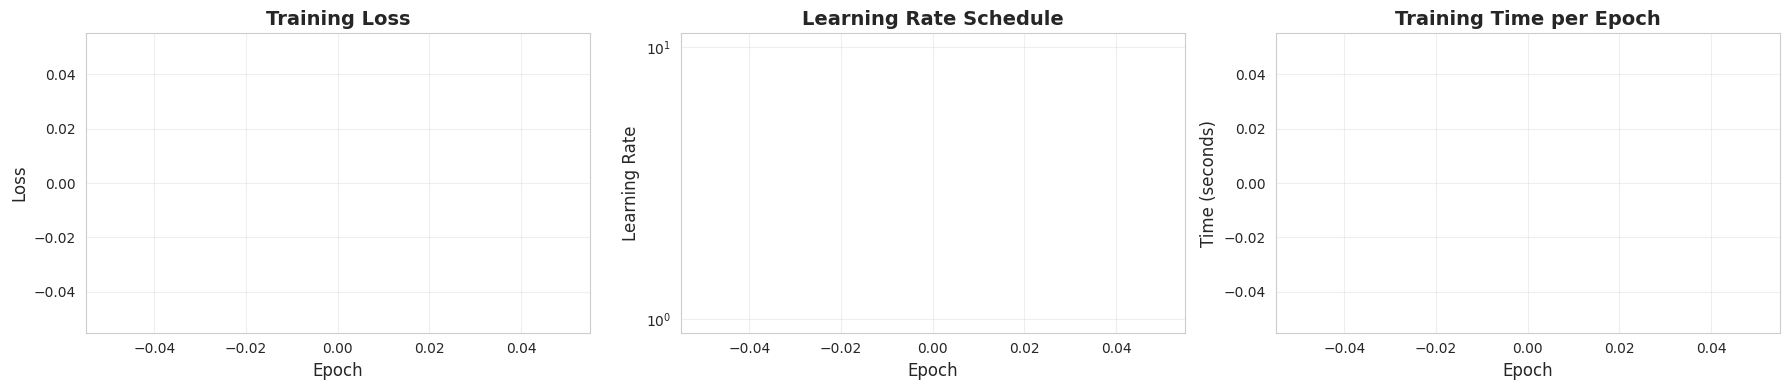


📊 Training curves saved to: /content/drive/MyDrive/benchmark/outputs/encoders/hgt_transformer_optimized/training_curves.png


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Training loss
axes[0].plot(history['train_loss'], linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['lr'], linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Epoch time
axes[2].plot(history['epoch_time'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training curves saved to: {save_dir / 'training_curves.png'}")

## 12. Generate Embeddings

In [13]:
if config.save_embeddings:
    print("\n🔄 Generating embeddings for all graphs...")

    # Load best model
    checkpoint = torch.load(save_dir / "best_encoder.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Create loader for full dataset
    full_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    embeddings_list = []
    metadata_list = []

    with torch.no_grad():
        for batch in tqdm(full_loader, desc="Generating embeddings"):
            batch = batch.to(config.device)

            # Get N_base and T
            N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
            T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()
            node_type = batch.node_type if hasattr(batch, 'node_type') else None

            embeddings = model(
                batch.x,
                batch.edge_index,
                batch.edge_type,
                node_type,
                N_base,
                T,
                batch=batch.batch if hasattr(batch, 'batch') else None,
                return_sequence=True,
            )

            # Handle batched or single graph
            if embeddings.dim() == 4:
                for i in range(embeddings.size(0)):
                    embeddings_list.append(embeddings[i].cpu().numpy())
                    metadata_list.append({"N_base": N_base, "T": T, "shape": list(embeddings[i].shape)})
            else:
                embeddings_list.append(embeddings.cpu().numpy())
                metadata_list.append({"N_base": N_base, "T": T, "shape": list(embeddings.shape)})

    # Save embeddings
    save_dict = {}
    for i, (emb, meta) in enumerate(zip(embeddings_list, metadata_list)):
        save_dict[f'embedding_{i:05d}'] = emb
        save_dict[f'metadata_{i:05d}'] = np.array(meta, dtype=object)

    save_dict['count'] = np.array(len(embeddings_list))

    embeddings_path = save_dir / 'embeddings.npz'
    np.savez_compressed(embeddings_path, **save_dict)

    print(f"\n✅ Saved {len(embeddings_list)} embeddings to: {embeddings_path}")
    print(f"   Total size: {embeddings_path.stat().st_size / 1e6:.2f} MB")
else:
    print("\nSkipping embedding generation (config.save_embeddings=False)")


🔄 Generating embeddings for all graphs...


/tmp/ipython-input-1760511823.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_dir / "best_encoder.pt")


Generating embeddings:   0%|          | 0/2000 [00:00<?, ?it/s]


✅ Saved 2000 embeddings to: /content/drive/MyDrive/benchmark/outputs/encoders/hgt_transformer_optimized/embeddings.npz
   Total size: 17068.69 MB


## 13. Training Summary

In [14]:
import pandas as pd

print("\n" + "="*80)
print("🎯 TRAINING SUMMARY")
print("="*80)

print(f"\n📊 Model Architecture:")
print(f"  - Type: HGT + Temporal Transformer (Encoder-only)")
print(f"  - Hidden dim: {config.hidden_dim}")
print(f"  - Spatial layers: {config.num_spatial_layers}")
print(f"  - Temporal layers: {config.num_temporal_layers}")
print(f"  - Attention heads: {config.num_heads}")
print(f"  - Total parameters: {total_params:,}")

print(f"\n📈 Training Results:")
print(f"  - Best loss: {best_loss:.6f}")
print(f"  - Final loss: {history['train_loss'][-1]:.6f}")
print(f"  - Total epochs: {config.epochs}")
print(f"  - Avg time per epoch: {np.mean(history['epoch_time']):.2f}s")
print(f"  - Total training time: {sum(history['epoch_time'])/3600:.2f} hours")

print(f"\n💾 Saved Files:")
print(f"  - Best model: {save_dir / 'best_encoder.pt'}")
if config.save_embeddings:
    print(f"  - Embeddings: {save_dir / 'embeddings.npz'}")
print(f"  - Training curves: {save_dir / 'training_curves.png'}")

print(f"\n🚀 Next Steps:")
print(f"  1. Use embeddings for EBM training")
print(f"  2. Analyze embedding quality (t-SNE, k-means)")
print(f"  3. Fine-tune on downstream tasks if needed")

print("\n" + "="*80)
print("✅ TRAINING COMPLETED SUCCESSFULLY!")
print("="*80 + "\n")


🎯 TRAINING SUMMARY

📊 Model Architecture:
  - Type: HGT + Temporal Transformer (Encoder-only)
  - Hidden dim: 64
  - Spatial layers: 1
  - Temporal layers: 1
  - Attention heads: 4
  - Total parameters: 221,440

📈 Training Results:
  - Best loss: inf


IndexError: list index out of range